In [1]:
import numpy as np
import pandas as pd
import numpy_groupies as npg

import os
import sys
import glob 
import itertools
import pickle

from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import tqdm.notebook as tqdm
import mne

from statsmodels.stats.multitest import multipletests

from utils.vis_3d import BrainSurface
from utils.plot import draw_four_views

In [2]:
import cupy as cp

def get_arr(x, baseline_correct=True, baseline_size=500):
    if type(x) is cp.ndarray:
        res = x.get()
    else:
        res = x
    
    if baseline_correct:
        res -= res[..., :baseline_size].mean(axis=-1, keepdims=True)

    return res

In [3]:
# output_path = 'L:\\nttk-data3\\palva\\Vlad\\pac_meg_tsdt_tfr_4.5_updated'
# output_path = 'L:\\nttk-data3\\palva\\Vlad\\pac_meg_tsdt_tfr_5.0_convolve_large'
output_path = 'L:\\nttk-data3\\palva\\Vlad\\pac_meg_tsdt_tfr_5.0_convolve_large'

subjects = glob.glob(os.path.join(output_path, '*'))

In [4]:
frequencies = np.geomspace(5, 100, 80)
n_frequencies = len(frequencies)

n_samples = 3000

n_parcels = 200

cue_types = {'att' : 0, 'non': 1, 'res': 2}

n_types = len(cue_types)

In [162]:
hit_subjectwise = np.zeros((len(subjects), n_types, n_frequencies, n_parcels, n_samples))
miss_subjectwise = np.zeros((len(subjects), n_types, n_frequencies, n_parcels, n_samples))

hit_amp_subjectwise = np.zeros((len(subjects), n_types, n_frequencies, n_parcels, n_samples))
miss_amp_subjectwise = np.zeros((len(subjects), n_types, n_frequencies, n_parcels, n_samples))

hit_evoked_subjectwise = np.zeros((len(subjects), n_types, n_frequencies, n_parcels, n_samples))
miss_evoked_subjectwise = np.zeros((len(subjects), n_types, n_frequencies, n_parcels, n_samples))

for subject_idx, subject_root in enumerate(subjects):
    # freqs  x parcels x trials x lags
    subject_files = glob.glob(os.path.join(subject_root, '*.npy'))
    
    subject_hit = np.zeros((n_types, n_frequencies, n_parcels, n_samples))
    subject_miss = np.zeros((n_types, n_frequencies, n_parcels, n_samples))
    
    subject_amp_hit = np.zeros((n_types, n_frequencies, n_parcels, n_samples))
    subject_amp_miss = np.zeros((n_types, n_frequencies, n_parcels, n_samples))
    
    subject_evoked_hit = np.zeros((n_types, n_frequencies, n_parcels, n_samples))
    subject_evoked_miss = np.zeros((n_types, n_frequencies, n_parcels, n_samples))
    
    subject_type_counter = np.zeros(n_types)

    for file_idx, fpath in enumerate(subject_files):
        subject_data = pickle.load(open(fpath, 'rb'))
        
        type_index = cue_types[subject_data['cue']]

        subject_hit[type_index] += get_arr(subject_data['hit']['pacf'])
        subject_miss[type_index] += get_arr(subject_data['miss']['pacf'])
        
        subject_amp_hit[type_index] += get_arr(subject_data['hit']['amplitude'])
        subject_amp_miss[type_index] += get_arr(subject_data['miss']['amplitude'])
        
        subject_evoked_hit[type_index] += get_arr(np.abs(subject_data['hit']['evoked']))
        subject_evoked_miss[type_index] += get_arr(np.abs(subject_data['miss']['evoked']))
        
        subject_type_counter[type_index] += 1    

    hit_subjectwise[subject_idx] = (subject_hit / subject_type_counter.reshape(-1,1,1,1))
    miss_subjectwise[subject_idx] = (subject_miss / subject_type_counter.reshape(-1,1,1,1))  
    
    hit_amp_subjectwise[subject_idx] = (subject_amp_hit / subject_type_counter.reshape(-1,1,1,1))
    miss_amp_subjectwise[subject_idx] = (subject_amp_miss / subject_type_counter.reshape(-1,1,1,1))  
    
    hit_evoked_subjectwise[subject_idx] = (subject_evoked_hit / subject_type_counter.reshape(-1,1,1,1))
    miss_evoked_subjectwise[subject_idx] = (subject_evoked_miss / subject_type_counter.reshape(-1,1,1,1))  

C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\vlamyr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


In [163]:
cohort_pacf_diff = np.nanmean(hit_subjectwise - miss_subjectwise, axis=0)
cohort_amp_diff = np.nanmean(hit_amp_subjectwise, axis=(0)) - np.nanmean(miss_amp_subjectwise, axis=(0))
cohort_evoked_diff = np.nanmean(hit_evoked_subjectwise, axis=(0)) - np.nanmean(miss_evoked_subjectwise, axis=(0))

In [164]:
cohort_pacf_diff_corr = cohort_pacf_diff.copy()

# for freq_idx, freq in enumerate(frequencies):
#     shift = -int(1000/freq*1.5)
#     cohort_pacf_diff_corr[:, freq_idx] = np.roll(cohort_pacf_diff[:, freq_idx], shift, axis=-1)

cohort_pacf_diff_avg_all = cohort_pacf_diff_corr.mean(axis=2) 

In [165]:
avg_hit = np.nanmean(hit_subjectwise[:, 1], axis=0) 
avg_miss = np.nanmean(miss_subjectwise[:, 1], axis=0)

In [166]:
finite_mask = np.isfinite(hit_subjectwise[:,1,0,0,0]) & np.isfinite(miss_subjectwise[:,1,0,0,0])

hit_subjectwise_finite = hit_subjectwise[finite_mask]
miss_subjectwise_finite = miss_subjectwise[finite_mask]

In [167]:


import scipy as sp
import scipy.spatial

In [168]:
pacf_diff_subjectwise = hit_subjectwise_finite[:,1] - miss_subjectwise_finite[:,1]

In [327]:
import numba

def compute_surr_diff(x, y, n_rounds=100):
    xy = np.concatenate([x,y], axis=0)

    labels = np.array([0]*len(x) + [1]*len(y))

    res = np.zeros((n_rounds, *x.shape[1:]))


    for i in tqdm.tqdm(np.arange(n_rounds)):
        np.random.shuffle(labels)

        for miss_idx in np.where(labels == 0)[0]:
            res[i] += xy[miss_idx]
        
        for hit_idx in np.where(labels == 1)[0]:
            res[i] -= xy[hit_idx]
        
        res[i] /= x.shape[0]

    return res

In [329]:
surr_diff = compute_surr_diff(hit_subjectwise_finite[:,1], miss_subjectwise_finite[:,1], n_rounds=500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [330]:
# surr_level_parcelwise = np.percentile(surr_diff, 99, axis=(0,-1), keepdims=True)

(1, 80, 200, 1)

In [ ]:
# cohort_pacf_diff_sign_pos = (cohort_pacf_diff[1] >= surr_level).transpose(1,0,2)
# cohort_pacf_diff_sign_neg = (cohort_pacf_diff[1] <= -surr_level).transpose(1,0,2)

cohort_pacf_diff_sign_pos = (cohort_pacf_diff[1] >= surr_level_parcelwise[0]).transpose(1,0,2)
cohort_pacf_diff_sign_neg = (cohort_pacf_diff[1] <= -surr_level_parcelwise[0]).transpose(1,0,2)


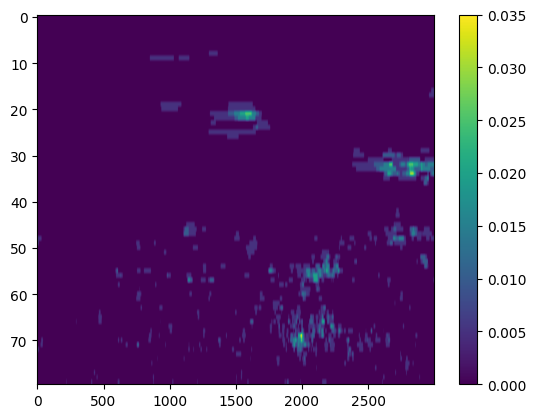

In [ ]:
plt.imshow(cohort_pacf_diff_sign_pos.mean(axis=(0)), aspect='auto')
plt.colorbar()

In [220]:
def jk_pacf_diff_sign(pacf_diff, surr_level_parcelwise):
    subject_mask = np.ones(pacf_diff_subjectwise.shape[0], dtype=bool)
    subject_mask[0] = False

    res_pos = np.zeros_like(pacf_diff)
    res_neg = np.zeros_like(pacf_diff)

    for i in range(pacf_diff.shape[0]):
        res_pos[i] = (pacf_diff[subject_mask].mean(axis=0) >= surr_level_parcelwise.reshape(1,-1,1))
        res_neg[i] = (pacf_diff[subject_mask].mean(axis=0) <= -surr_level_parcelwise.reshape(1,-1,1))
 

        subject_mask = np.roll(subject_mask, 1)

    return res_pos, res_neg

In [221]:
jk_sign_pos, jk_sign_neg = jk_pacf_diff_sign(pacf_diff_subjectwise, surr_level_parcelwise)

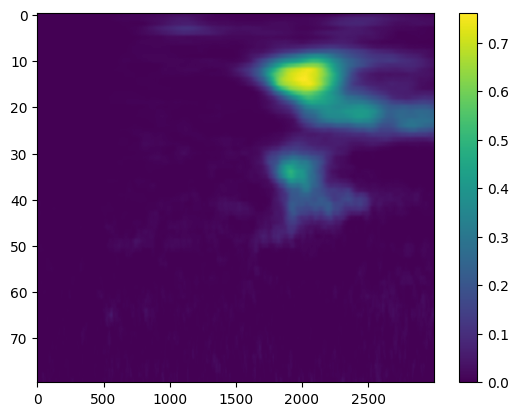

In [222]:
plt.imshow(jk_sign_neg.mean(axis=(0,2)), aspect='auto')
plt.colorbar()

In [187]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [188]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from utils.vis_3d import BrainSurface
from utils.plot import draw_four_views

In [189]:
from matplotlib._cm import _Blues_data, _Reds_data

_Blues_data_fixed = list(_Blues_data)
_Blues_data_fixed[0] = [1.0, 1.0, 1.0]

_Reds_data_fixed = list(_Reds_data)
_Reds_data_fixed[0] = [1.0, 1.0, 1.0]

In [190]:
fsaverage_path = r'L:\nttk-data2\palva\Common repos\_fsaverage\fsaverage'

brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_200Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_200Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')

brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]
parcel_names_fixed = [p.split('-')[0] for p in subject_data['parcel_names']]
surf_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]

parcel_names_matched = sorted(surf_parcel_names)

In [191]:
blues_fixed = LinearSegmentedColormap.from_list('Blues_fixed', _Blues_data_fixed, N=256)
reds_fixed = LinearSegmentedColormap.from_list('Reds_fixed', _Reds_data_fixed, N=256)

In [192]:
from sklearn.preprocessing import LabelEncoder

import numpy_groupies as npg

import string

In [193]:
cohort_pacf_diff_sign_both = cohort_pacf_diff_sign_pos.mean(axis=0) - cohort_pacf_diff_sign_neg.mean(axis=0)

In [194]:
parcel_subsystems = [p.split('_')[2] for p in parcel_names_fixed]
subsystem_encoder = LabelEncoder().fit(parcel_subsystems)
parcel_subsystem_labels = subsystem_encoder.transform(parcel_subsystems)

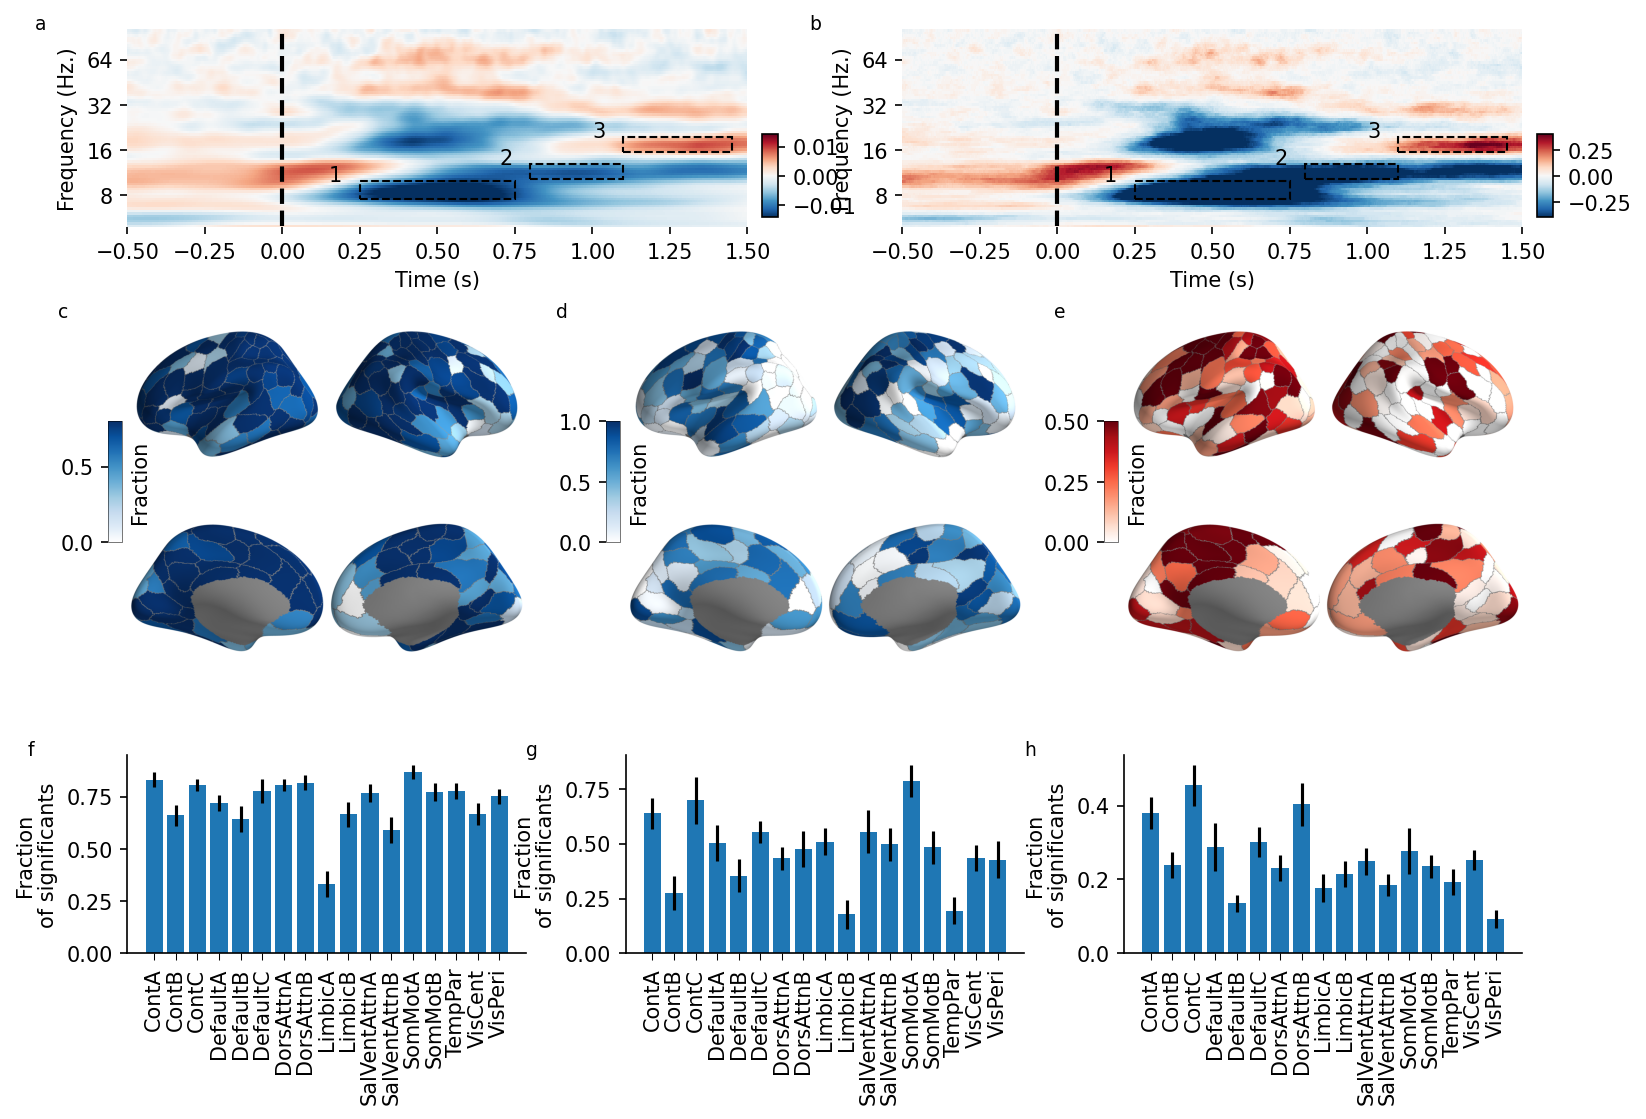

In [195]:
fig = plt.figure(figsize=(12,8), dpi=150, constrained_layout=False)
main_spec = fig.add_gridspec(nrows=3, ncols=1, hspace=0.25, height_ratios=[1,2,1])

gs_top = main_spec[0].subgridspec(ncols=2, nrows=1, wspace=0.25)
gs_brain_cols = main_spec[1].subgridspec(ncols=3, nrows=1, hspace=0.1, wspace=0.25)
gs_bot = main_spec[2].subgridspec(ncols=3, nrows=1, wspace=0.25)

axes = np.empty((6,6), dtype=object)

for i in range(2):
    axes[0,i] = fig.add_subplot(gs_top[i])
        
for i, j in itertools.product(range(1), range(3)):
    brain_gs = gs_brain_cols[i,j].subgridspec(2,2, wspace=0, hspace=0)
    for nr, nc in itertools.product(range(2), range(2)):
        axes[i*2+nr + 1, j*2+nc] = fig.add_subplot(brain_gs[nr,nc])

for i in range(3):
    axes[3,i] = fig.add_subplot(gs_bot[i])


vmax = np.percentile(np.abs(cohort_pacf_diff_avg_all[1]), 99)
vmin = -vmax

imh0 = axes[0, 0].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_pacf_diff_avg_all[1], cmap='RdBu_r', vmin=vmin, vmax=vmax)
imh1 = axes[0, 1].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_pacf_diff_sign_both, cmap='RdBu_r', vmin=-0.4, vmax=0.4)

cbar_ax0 = inset_axes(axes[0, 0],                  
                 width="2.5%",  # width = 10% of parent_bbox width
                 height="40%",  # height : 50%
                 loc='lower right',
                 bbox_to_anchor=(0, 0.05, 1.05, 1.05),
                 bbox_transform=axes[0, 0].transAxes,
                 borderpad=0,
                 )
cbar_ax1 = inset_axes(axes[0, 1],                  
                 width="2.5%",  # width = 10% of parent_bbox width
                 height="40%",  # height : 50%
                 loc='lower right',
                 bbox_to_anchor=(0, 0.05, 1.05, 1.05),
                 bbox_transform=axes[0,1].transAxes,
                 borderpad=0,) 

fig.colorbar(imh0, cax=cbar_ax0)
fig.colorbar(imh1, cax=cbar_ax1)

draw_four_views(axes[1:3, 0:2], cohort_pacf_diff_sign_neg[:, 11:18, 1750:2250].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 0.8), cmap=blues_fixed) 
draw_four_views(axes[1:3, 2:4], cohort_pacf_diff_sign_neg[:, 19:25, 2100:2500].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 1.0), cmap=blues_fixed) 
draw_four_views(axes[1:3, 4:6], cohort_pacf_diff_sign_pos[:, 30:36, 2600:].mean(axis=(-1,-2)), parcel_names_matched, brain_3d_surfaces, norm_values=(0, 0.5), cmap=reds_fixed) 


effect_one_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_neg[:, 11:18, 1750:2250].mean(axis=(-1,-2)), func='mean')
effect_two_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_neg[:, 19:25, 2300:2600].mean(axis=(-1,-2)), func='mean')
effect_three_systemwise = npg.aggregate(parcel_subsystem_labels, cohort_pacf_diff_sign_pos[:, 30:36, 2600:].mean(axis=(-1,-2)), func='mean')

effect_one_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_neg[:, 11:18, :, 1750:2250].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)
effect_two_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_neg[:, 19:25, :, 2300:2600].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)
effect_three_std_systemwise = npg.aggregate(parcel_subsystem_labels, jk_sign_pos[:, 30:36, :, 2600:].mean(axis=(-1,-3)), axis=-1, func='mean').std(axis=0)


axes[3,0].bar(subsystem_encoder.classes_, effect_one_systemwise, yerr=effect_one_std_systemwise)
axes[3,1].bar(subsystem_encoder.classes_, effect_two_systemwise, yerr=effect_two_std_systemwise)
axes[3,2].bar(subsystem_encoder.classes_, effect_three_systemwise, yerr=effect_three_std_systemwise)

for area_idx, ((f_start, f_end), (t_start, t_end)) in enumerate(zip(zip(frequencies[[11,19,30]], frequencies[[18, 25, 36]]), zip([0.25, 0.8, 1.1], [0.75, 1.1, 1.45]))):
    axes[0,0].add_patch(plt.Rectangle((t_start, f_start), t_end - t_start, f_end - f_start, ls="--", lw=1, ec="black", fc="none"))
    axes[0,1].add_patch(plt.Rectangle((t_start, f_start), t_end - t_start, f_end - f_start, ls="--", lw=1, ec="black", fc="none"))

    axes[0,0].text(t_start - 0.1, f_end, area_idx + 1)
    axes[0,1].text(t_start - 0.1, f_end, area_idx + 1)

for ax in axes[3, :3]:
    ax.tick_params(axis='x', rotation=90, width=0.5)
    ax.set_ylabel('Fraction\nof significants')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    _, ymax = ax.get_ylim()
    ax.set_ylim([0, ymax])

for ax in axes[0, :2]:
    ax.set_yscale('log')

    # ax.set_yticks(frequencies[::10].astype(int))
    # ax.set_yticklabels(frequencies[::10].astype(int))
    ax.set_yticks(2**np.arange(2, 7))
    ax.set_yticklabels(2**np.arange(2, 7))

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.minorticks_off()

    ax.set_ylabel('Frequency (Hz.)')
    ax.set_xlabel('Time (s)')

    ax.set_xlim([-0.5, 1.5])

    ax.plot([0, 0], frequencies[[0,~0]], color='black', ls='--', lw=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

for ax in fig.axes[-3:]:
    ax.set_ylabel('Fraction', fontsize=10)

for ax, label in zip(axes[0,:2], string.ascii_lowercase):
    ax.text(-0.15, 1, label, fontsize=9, transform=ax.transAxes)

for ax, label in zip(axes[1, [0,2,4]].tolist(), string.ascii_lowercase[2:]):
    ax.text(-0.35, 1, label, fontsize=9, transform=ax.transAxes)

for ax, label in zip(axes[3,:3], string.ascii_lowercase[5:]):
    ax.text(-0.25, 1, label, fontsize=9, transform=ax.transAxes)

fig.savefig('publication_figures/figure_8_tsdt.png', dpi=300, bbox_inches="tight")

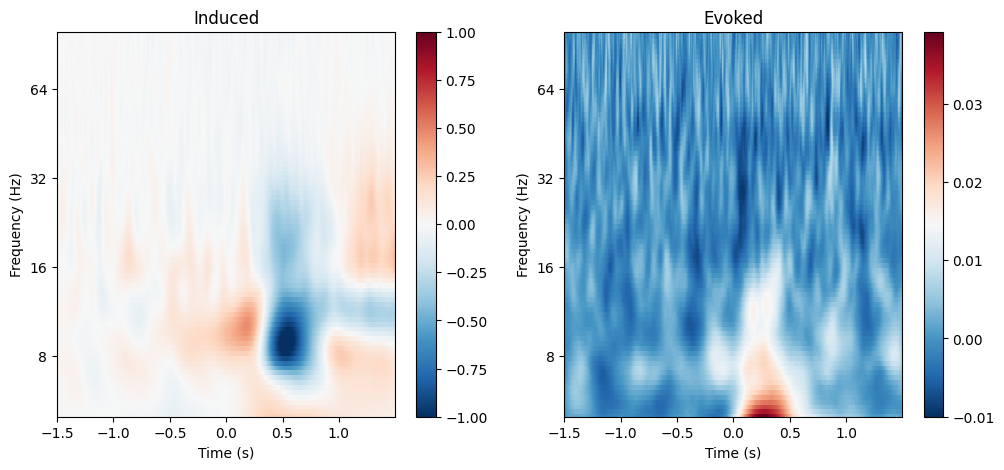

In [197]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2)

imh2 = axes[0].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_amp_diff[1].mean(axis=1)*1e11, cmap='RdBu_r', vmin=-1, vmax=1)
fig.colorbar(imh2, ax=axes[0])

imh3 = axes[1].pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, cohort_evoked_diff[1].mean(axis=1), cmap='RdBu_r')
fig.colorbar(imh3, ax=axes[1])


for ax, title in zip(axes, ['Induced', 'Evoked']):
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    
    ax.set_yscale('log')

    # ax.set_yticks(frequencies[::10].astype(int))
    # ax.set_yticklabels(frequencies[::10].astype(int))
    ax.set_yticks(2**np.arange(2, 7))
    ax.set_yticklabels(2**np.arange(2, 7))

    ax.set_ylim(frequencies[[0, ~0]])

    ax.yaxis.set_minor_formatter(mticker.NullFormatter())
    ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

    ax.minorticks_off()

fig.set_facecolor('white') 
fig.savefig('publication_figures/figure_8_tsdt_supp.png', dpi=300, bbox_inches='tight')

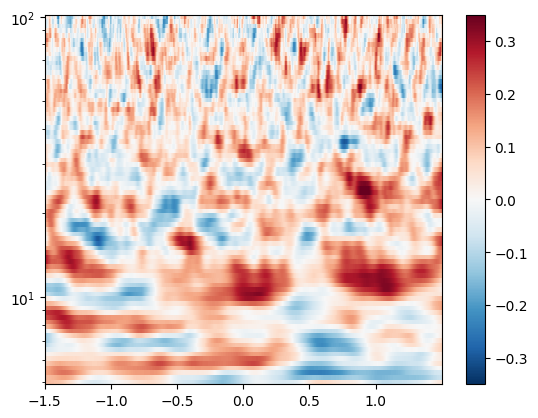

In [72]:
plt.pcolormesh(np.arange(3000)/1000 - 1.5, frequencies, induced_vs_pacf_corr, cmap='RdBu_r', vmin=-.35, vmax=0.35)
plt.yscale('log')
plt.colorbar()

In [ ]:
from numpy.lib.stride_tricks import normalize_axis_tuple

def cupy_sliding_window_view(x, window_shape, axis=None, *,
                        subok=False, writeable=False):
    window_shape = (tuple(window_shape)
                    if np.iterable(window_shape)
                    else (window_shape,))
    # first convert input to array, possibly keeping subclass
    x = cp.array(x, copy=False, subok=subok)

    window_shape_array = np.array(window_shape)
    if np.any(window_shape_array < 0):
        raise ValueError('`window_shape` cannot contain negative values')

    if axis is None:
        axis = tuple(range(x.ndim))
        if len(window_shape) != len(axis):
            raise ValueError(f'Since axis is `None`, must provide '
                             f'window_shape for all dimensions of `x`; '
                             f'got {len(window_shape)} window_shape elements '
                             f'and `x.ndim` is {x.ndim}.')
    else:
        axis = normalize_axis_tuple(axis, x.ndim, allow_duplicate=True)
        if len(window_shape) != len(axis):
            raise ValueError(f'Must provide matching length window_shape and '
                             f'axis; got {len(window_shape)} window_shape '
                             f'elements and {len(axis)} axes elements.')

    out_strides = x.strides + tuple(x.strides[ax] for ax in axis)

    # note: same axis can be windowed repeatedly
    x_shape_trimmed = list(x.shape)
    for ax, dim in zip(axis, window_shape):
        if x_shape_trimmed[ax] < dim:
            raise ValueError(
                'window shape cannot be larger than input array shape')
        x_shape_trimmed[ax] -= dim - 1
    out_shape = tuple(x_shape_trimmed) + window_shape
    return cp.lib.stride_tricks.as_strided(x, strides=out_strides, shape=out_shape)